## 导入实验所需模块

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import platform
import sys
from six.moves import cPickle as pickle

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Activation
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from tensorflow.keras import backend as K

Using TensorFlow backend.


## 自定义加载数据函数

In [4]:
def load_batch(fpath, label_key='labels'):
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]
 
    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

In [5]:
def load_data(ROOT):
    path = ROOT
    num_train_samples = 50000 
    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8') 
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)
 
    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath) 
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1) 
    return (x_train, y_train), (x_test, y_test)

## 加载数据

In [6]:
(X_train, y_train), (X_test, y_test) = load_data('./dataset')

## 查看数据形状、类型

In [7]:
print(X_train.shape,y_train.shape)
print(type(X_train),type(y_train))

(50000, 32, 32, 3) (50000, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 查看前十张图片

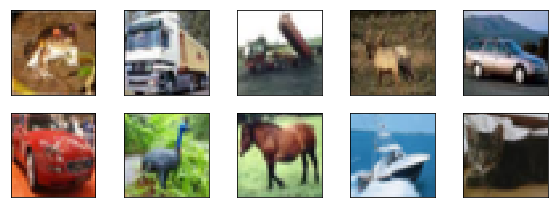

In [8]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

## 查看每类图片（各一张）

In [9]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

idx = np.where(y_train[:]==i)

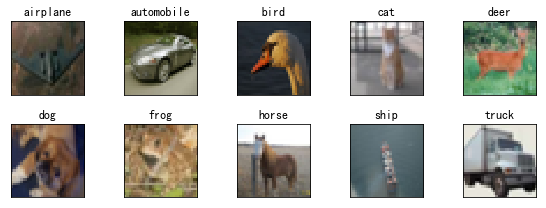

In [10]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

## 图片预处理

In [11]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = c.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# 将标签转化为热编码形式
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# 将图像每一位像素设定在[-1,1]之间（为了使用tanh函数）
X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

## 定义生成器

In [12]:
# 噪声z初始维度
latent_dim = 100
#权重初始化为均值为0，标准差为0.02的正态分布
init = initializers.RandomNormal(stddev=0.02)

# 开始建立生成网络
generator = Sequential()

# 第一层使用全连接，其余层使用微步幅度卷积、批处理
# 最后一层使用tanhx激活函数，其余层均使用RuLu激活函数

# 1x100 ——> 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
# 2x2x512 ——> 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
# 4x4x256 ——> 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
# 8x8x128 ——> 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
# 6x16x64 ——> 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('tanh'))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# 查看判别网络细节
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 4, 256)         0         
__________

## 定义判别器

In [14]:
# 判别器输入图像的形状
img_shape = X_train[0].shape

# 开始建立判别网络
discriminator = Sequential()
#使用步幅卷积代替池化层
#除最后一层使用使用sigmoid激活函数，其余层均使用LeakyRelu函数作为激活函数

# 32x32x3 ——> 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 16x16x64 ——> 8x8x128
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 8x8x128 ——> 4x4x256
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 4x4x256 ——> 2x2x512
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 2x2x512 ——> 2048
discriminator.add(Flatten())
# 输出使用FC，为一维
discriminator.add(Dense(1, activation='sigmoid'))

In [15]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

## 判别器优化器，形成最优的D

In [16]:
# 优化器:Adam优化器，学习率0.0002，动量0.5
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

## 连接生成器和判别器，构建DCGAN网络

In [17]:
discriminator.trainable = False
z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

In [18]:
# DCGAN网络细节
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516751   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312449   
Total params: 8,829,200
Trainable params: 4,514,825
Non-trainable params: 4,314,375
_________________________________________________________________


## DCGAN优化器，形成最优的G

In [19]:
d_g.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

## 训练

Instructions for updating:
Use tf.cast instead.
epoch = 1/50, d_loss=0.177, g_loss=0.392                                                                                                                                                                                                                            


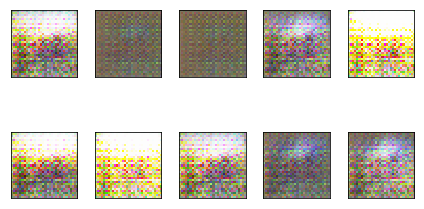

epoch = 2/50, d_loss=0.255, g_loss=0.247                                                                                                                         
epoch = 3/50, d_loss=0.168, g_loss=0.216                                                                                                                         
epoch = 4/50, d_loss=0.167, g_loss=0.059                                                                                                                                                                                                                            
epoch = 5/50, d_loss=0.164, g_loss=0.038                                                                                                                         
epoch = 6/50, d_loss=0.169, g_loss=0.103                                                                                                                                                                                                                     

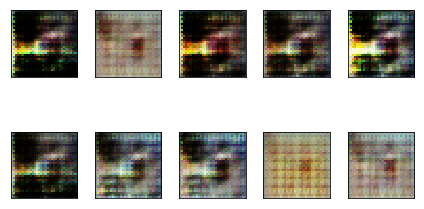

epoch = 12/50, d_loss=0.204, g_loss=0.172                                                                                                                                                                                                                                                                                                                                
epoch = 13/50, d_loss=0.174, g_loss=0.049                                                                                                                        
epoch = 14/50, d_loss=0.166, g_loss=0.125                                                                                                                                                                                                                                                                                                                                
epoch = 15/50, d_loss=0.168, g_loss=0.197                                                                         

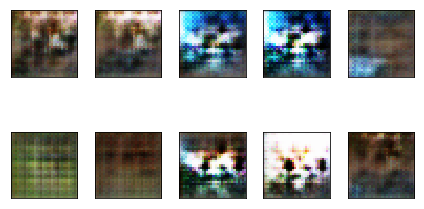

epoch = 22/50, d_loss=0.202, g_loss=0.176                                                                                                                                                                                                                                                                                                                                
epoch = 23/50, d_loss=0.171, g_loss=0.119                                                                                                                         
epoch = 24/50, d_loss=0.166, g_loss=0.119                                                                                                                                                                                                                            
epoch = 25/50, d_loss=0.170, g_loss=0.344                                                                                                                        
epoch = 26/50, d_loss=0.168, g_loss=0.493          

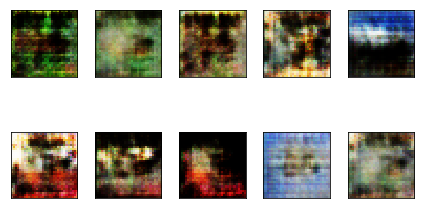

epoch = 32/50, d_loss=0.233, g_loss=1.925                                                                                                                                                                                                                           
epoch = 33/50, d_loss=0.173, g_loss=0.087                                                                                                                                                                                                                            
epoch = 34/50, d_loss=0.176, g_loss=0.054                                                                                                                                                                                                                                                                                                                                                                                                                                   
epoch = 35/50, d

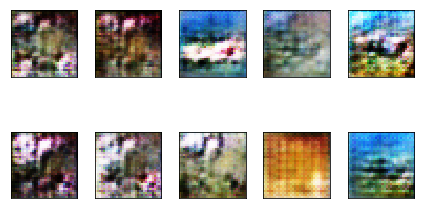

epoch = 42/50, d_loss=0.168, g_loss=0.460                                                                                                                        
epoch = 43/50, d_loss=0.175, g_loss=0.121                                                                                                                        
epoch = 44/50, d_loss=0.172, g_loss=0.250                                                                                                                                                                                                                           
epoch = 45/50, d_loss=0.168, g_loss=0.112                                                                                                                        
epoch = 46/50, d_loss=0.307, g_loss=1.749                                                                                                                                                                                                                    

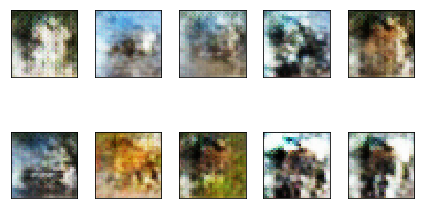

In [20]:
# 训练轮次
epochs = 50
# 每批数量
batch_size = 32
# 查阅资料发现设置smooth参数会有较好的效果
smooth = 0.1
# G训练时使得D(G(z))为real
# D训练时使得D(G(z))为fake，D(X_train[i])为real
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))
# 用来存储生成器和判别器的损失
d_loss = []
g_loss = []
# 开始训练
for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):        
        
        # 训练判别器
        discriminator.trainable = True        
        # 输入真实数据，期望结果为real
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,y=real * (1 - smooth))       
        # 输入生成器生成的数据，期望结果为fake
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
        # 判别器损失，之后与生成器损失放在同一图中，便于观察乘以系数 0.5
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # 训练DCGAN（即生成器）
        discriminator.trainable = False
        # 输入生成器生成的数据，期望结果为real
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

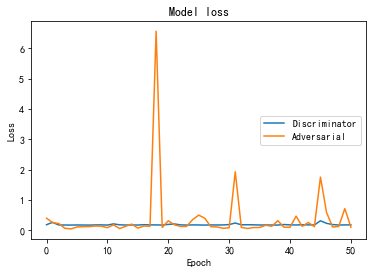

In [21]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()